In [19]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import time
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from lazyvi import LazyVI
from data_generating_funcs import generate_linear_data, MNISTDataModule
from networks import NN4vi, UltraLiteMNIST



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def dropout_chunk(X, j, k, chunk_size=4):
    X = np.array(X)
    N = X.shape[0]
    X_change = np.copy(X)
    X_change[:, j:j+chunk_size, k:k+chunk_size] = X_change[:, j:(j+chunk_size), k:(k+chunk_size)].mean(axis=0)
    X_change = torch.tensor(X_change, dtype=torch.float32)
    return X_change

In [3]:
dm = MNISTDataModule()
dm.setup()
model = UltraLiteMNIST()
early_stopping = EarlyStopping('train_loss', min_delta=1e-3)
trainer = pl.Trainer(callbacks=[early_stopping], max_epochs=100)
trainer.fit(model, dm)

X_train = dm.train_dataset.dataset.data
y_train = dm.train_dataset.dataset.targets

X_test = dm.test_dataset.data
y_test = dm.test_dataset.targets

print('training acc: ', torch.sum(y_train == torch.round(model(X_train))).item() / len(y_train) * 1.0)
acc0 = torch.sum(y_test == torch.round(model(X_test))).item() / len(y_test) * 1.0
acc0

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

training acc:  0.9949924887330996


0.9818548387096774

In [9]:
# full lazyvi
lam0 = np.sqrt(X_train.shape[0]) # fix regularization for speed
lv = LazyVI(model, lam=lam0)
lv.fit(X_train, y_train)

acc0_lazy = torch.sum(y_test == torch.round(lv.predict(X_test))).item() / len(y_test) * 1.0
acc0_lazy

0.9803427419354839

In [42]:
omg = []
for t in range(10):
    for j in np.arange(0, 28, chunk_size):
        for k in np.arange(0, 28, chunk_size):
            for jj in range(j, j+chunk_size):
                for kk in range(k, k+chunk_size):
                    omg.append('lol1')
                    omg.append('lol2')

In [10]:
dm = MNISTDataModule(dropout=[0,0], chunk_size=2)
dm.setup()
X_train = dm.train_dataset.dataset.data

In [37]:
results = []
chunk_size = 4
for t in range(1):
    print(f'=========={t}===========')
    dm = MNISTDataModule()
    dm.setup()
    model = UltraLiteMNIST()
    early_stopping = EarlyStopping('train_loss', min_delta=1e-4)
    trainer = pl.Trainer(callbacks=[early_stopping], max_epochs=10)
    trainer.fit(model, dm)

    X_train = dm.train_dataset.dataset.data
    y_train = dm.train_dataset.dataset.targets

    X_test = dm.test_dataset.data
    y_test = dm.test_dataset.targets

    print('training acc: ', torch.sum(y_train == torch.round(model(X_train))).item() / len(y_train) * 1.0)
    acc0 = torch.sum(y_test == torch.round(model(X_test))).item() / len(y_test) * 1.0
    chunk_size = 4
    lam0 = np.sqrt(X_train.shape[0])
    for j in np.arange(0, 28, chunk_size):
        print(j)
        for k in np.arange(0, 28, chunk_size):
            print(k)
            Xj_train = dropout_chunk(X_train, j, k, chunk_size)
            Xj_test = dropout_chunk(X_test, j, k, chunk_size)
            # dropout
            acc_dr = torch.sum(y_test == torch.round(model(Xj_test))).item() / len(y_test) * 1.0
            # retrain
            t0 = time.time()
            dmj = MNISTDataModule(dropout=[j,k], chunk_size=chunk_size)
            model_rt = UltraLiteMNIST()
            trainer_rt = pl.Trainer(callbacks=[early_stopping], max_epochs=10)
            trainer_rt.fit(model_rt, dmj)
            acc_rt = torch.sum(y_test == torch.round(model_rt(Xj_test))).item() / len(y_test) * 1.0
            rt_time = time.time() - t0
            for jj in range(j, j+chunk_size):
                    for kk in range(k, k+chunk_size):
                        results.append([t, jj, kk, 'retrain', rt_time, acc_rt, acc0])
                        results.append([t, jj, kk, 'dropout', 0, acc_dr, acc0])
            # lazy path
            for lam in np.logspace(-1, 2, 10):
                t0 = time.time()
                lv = LazyVI(model, lam=lam)
                lv.fit(Xj_train, y_train)
                acc_jk = torch.sum(y_test == torch.round(lv.predict(Xj_test))).item() / len(y_test) * 1.0
                lazy_time = time.time() - t0
                for jj in range(j, j+chunk_size):
                    for kk in range(k, k+chunk_size):
                        results.append([t, jj, kk, 'lazy', lazy_time, acc_jk, acc0, lam])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


==========0===========



  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


training acc:  0.9730428976798531
0
0


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


4


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


8



  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


12



  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


16



  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [30]:
df = pd.DataFrame(results, columns=['iter', 'j', 'k', 'method', 'time', 'reduced_accuracy', 'full_accuracy', 'lam'])
df['vi'] = df.full_accuracy - df.reduced_accuracy
df['vi_clipped'] = df.vi.apply(lambda x: max(x,0))

In [35]:
df

,iter,j,k,method,time,reduced_accuracy,full_accuracy,lam,vi,vi_clipped
0,0,0,0,retrain,5.190454,0.966734,0.972278,NaN,0.005544,0.005544
1,0,0,0,dropout,0.000000,0.972278,0.972278,NaN,0.000000,0.000000
2,0,0,1,retrain,5.190454,0.966734,0.972278,NaN,0.005544,0.005544
3,0,0,1,dropout,0.000000,0.972278,0.972278,NaN,0.000000,0.000000
4,0,1,0,retrain,5.190454,0.966734,0.972278,NaN,0.005544,0.005544
...,...,...,...,...,...,...,...,...,...,...
991,0,3,13,lazy,6.240179,0.967742,0.972278,4.641589,0.004536,0.004536
992,0,2,12,lazy,6.292694,0.970766,0.972278,10.000000,0.001512,0.001512
993,0,2,13,lazy,6.292694,0.970766,0.972278,10.000000,0.001512,0.001512
994,0,3,12,lazy,6.292694,0.970766,0.972278,10.000000,0.001512,0.001512


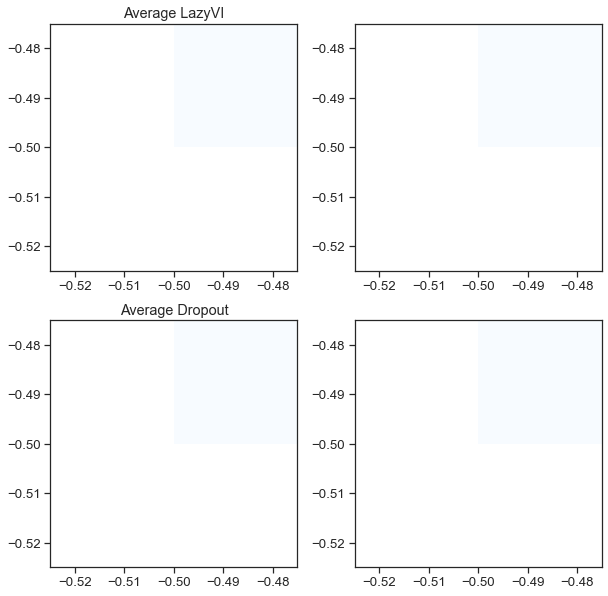

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

trial = 9

ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df[(df.method=='lazy')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df[(df.method=='lazy')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)

ax3.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im3= ax3.imshow(df[(df.method=='dropout')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax4.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im4 = ax4.imshow(df[(df.method=='dropout')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)


ax1.title.set_text('Average LazyVI')
ax3.title.set_text('Average Dropout')

<AxesSubplot:xlabel='lam'>

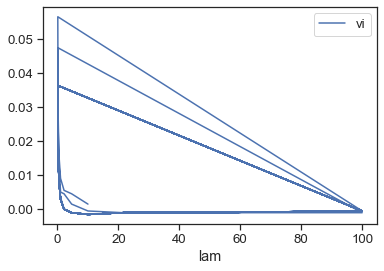

In [31]:
df[df.method=='lazy'][['lam', 'vi']].plot('lam')

In [52]:
df = pd.DataFrame(results, columns=['iter', 'j', 'k', 'method', 'reduced_accuracy', 'full_accuracy'])
df['vi'] = df.full_accuracy - df.reduced_accuracy
df['vi_clipped'] = df.vi.apply(lambda x: max(x,0))

In [60]:
df = df[df.full_accuracy.notnull()].reset_index(drop=True)

In [61]:
df.to_csv('../paper_simulations/results/mnist_2x2_dropout.csv', index=False)

In [5]:
dm = MNISTDataModule()
dm.setup()

X_train = dm.train_dataset.dataset.data
y_train = dm.train_dataset.dataset.targets

X_test = dm.test_dataset.data
y_test = dm.test_dataset.targets

In [22]:
df = pd.read_csv('../paper_simulations/results/mnist_2x2_dropout.csv')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='iter', ylabel='full_accuracy'>

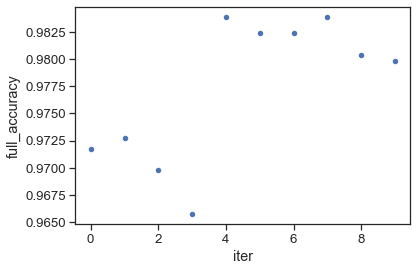

In [3]:
df[['iter', 'full_accuracy']].drop_duplicates().plot.scatter(0,1)

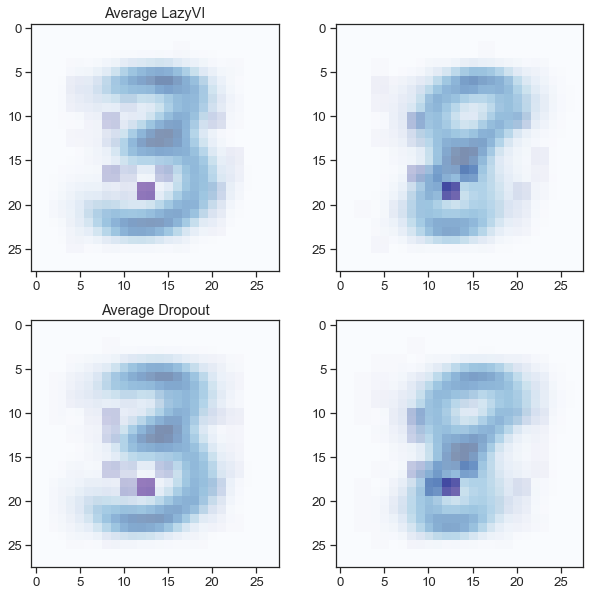

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

trial = 9

ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df[(df.method=='lazy')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df[(df.method=='lazy')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)

ax3.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im3= ax3.imshow(df[(df.method=='dropout')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax4.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im4 = ax4.imshow(df[(df.method=='dropout')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)


ax1.title.set_text('Average LazyVI')
ax3.title.set_text('Average Dropout')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

trial = 9

ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df[(df.method=='lazy')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df[(df.method=='lazy')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)

ax3.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im3= ax3.imshow(df[(df.method=='dropout')&(df.iter==trial)
                  ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax4.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im4 = ax4.imshow(df[(df.method=='dropout')&(df.iter==trial)
                   ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)


ax1.title.set_text('Average LazyVI')
ax3.title.set_text('Average Dropout')

In [15]:
lazy = []
dropout = []
for j in range(10):
    tmp = df[(df.iter==j)&(df.method=='lazy')]
    lazy.append(tmp.pivot_table(index='j', columns='k', values='vi_clipped').values)
    tmp = df[(df.iter==j)&(df.method=='dropout')]
    dropout.append(tmp.pivot_table(index='j', columns='k', values='vi_clipped').values)
lazy = np.array(lazy)
dropout = np.array(dropout)

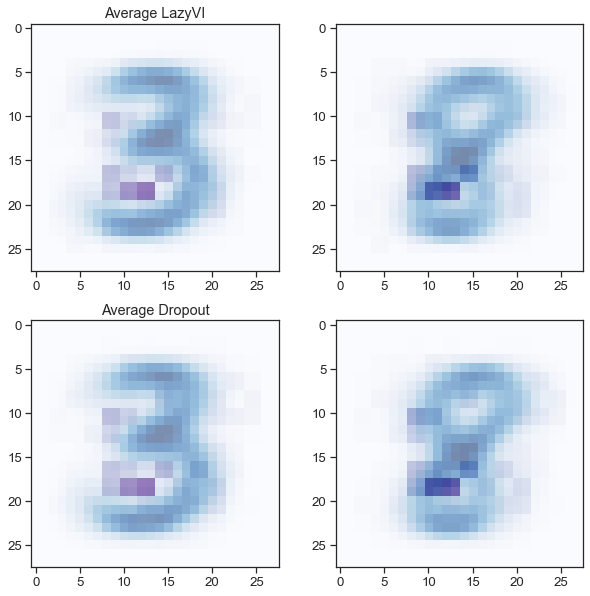

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(lazy.mean(axis=0), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(lazy.mean(axis=0), cmap='Purples', alpha=.5)

ax3.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im3= ax3.imshow(dropout.mean(axis=0), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax4.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im4 = ax4.imshow(dropout.mean(axis=0), cmap='Purples', alpha=.5)

ax1.title.set_text('Average LazyVI')
ax3.title.set_text('Average Dropout')

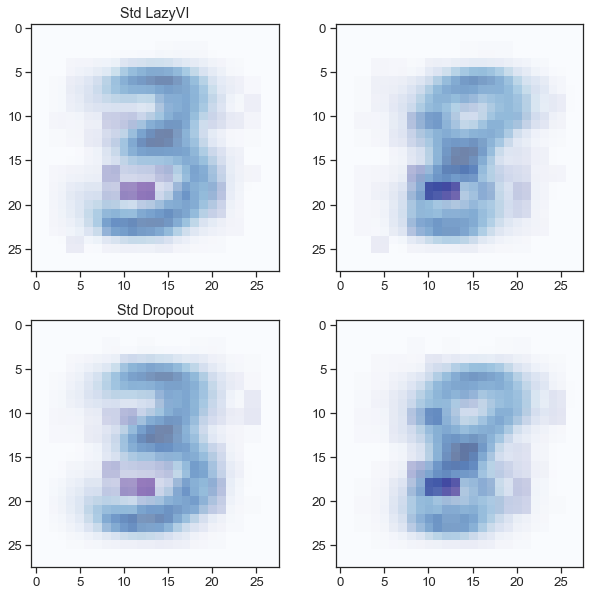

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(lazy.std(axis=0), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(lazy.std(axis=0), cmap='Purples', alpha=.5)

ax3.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im3= ax3.imshow(dropout.std(axis=0), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax4.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im4 = ax4.imshow(dropout.std(axis=0), cmap='Purples', alpha=.5)

ax1.title.set_text('Std LazyVI')
ax3.title.set_text('Std Dropout')

In [25]:
ax

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

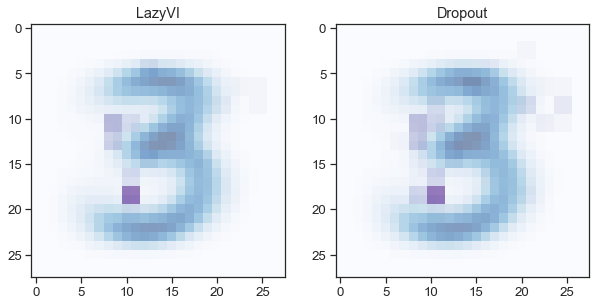

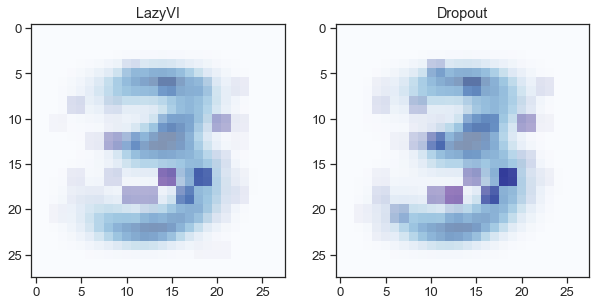

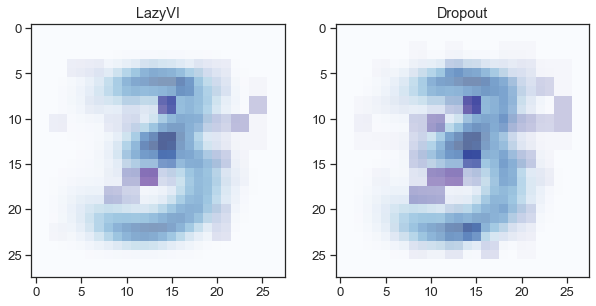

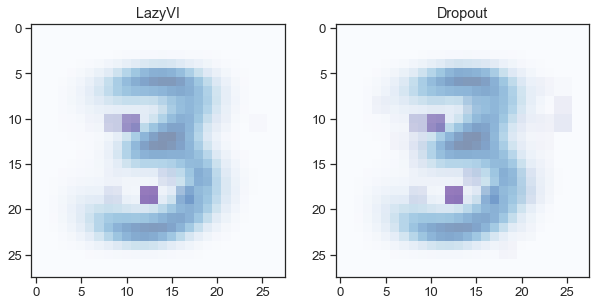

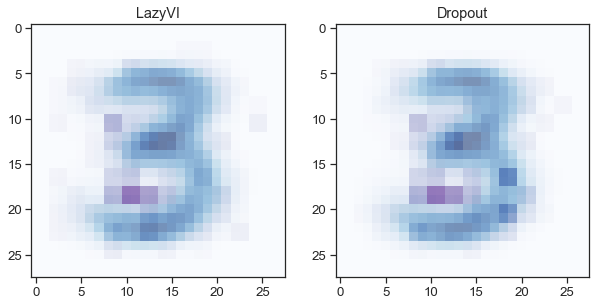

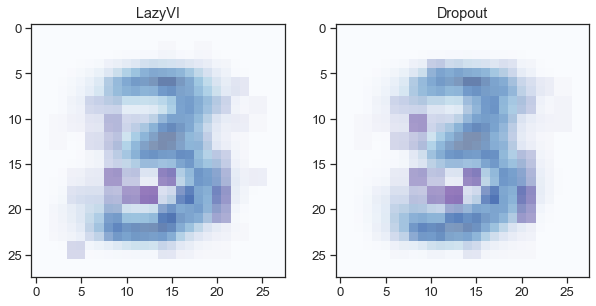

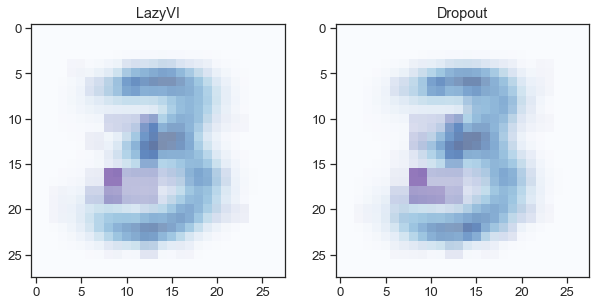

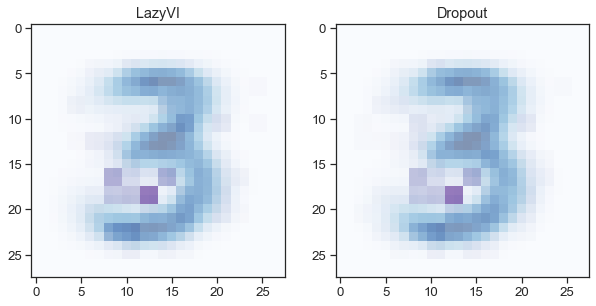

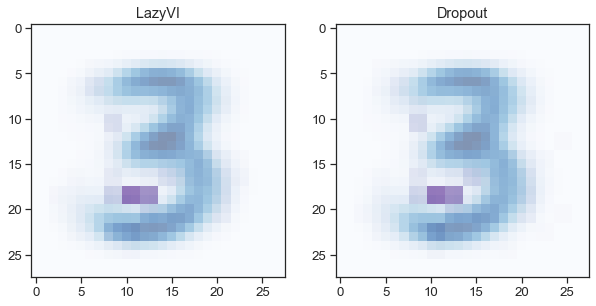

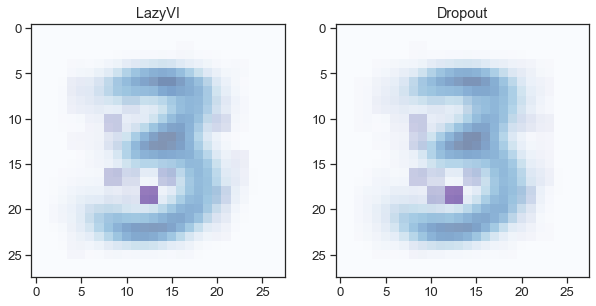

In [29]:
for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax1 = ax[0]
    ax2 = ax[1]

    ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
    im1= ax1.imshow(df[(df.method=='lazy')&(df.iter==i)
                      ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
    ax2.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
    im2= ax2.imshow(df[(df.method=='dropout')&(df.iter==i)
                      ].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
    ax1.title.set_text('LazyVI')
    ax2.title.set_text('Dropout')
    fig.savefig(f'drvlz_{i}.png')

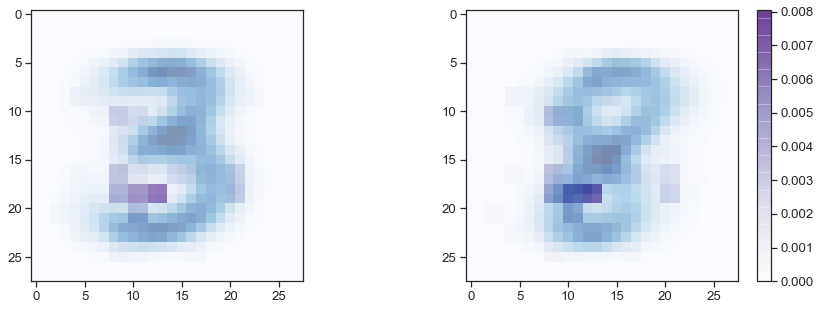

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df[df.method=='dropout'].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df[df.method=='dropout'].pivot_table(index='j', columns='k', values='vi_clipped'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

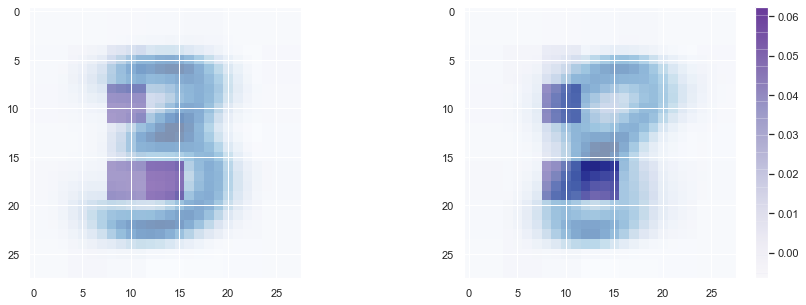

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='vi_full'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='vi_full'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

In [52]:
df = pd.read_csv('../results/mnist2x2.csv')

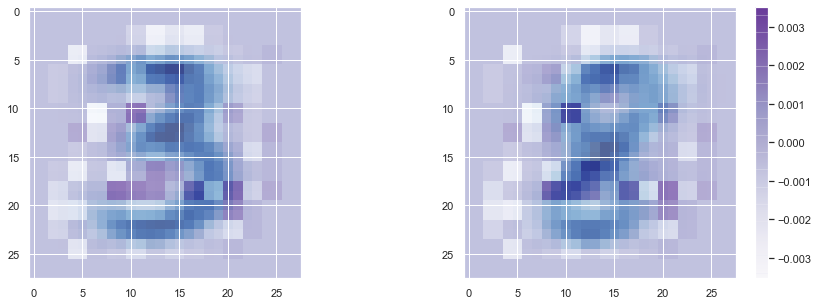

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='vi'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='vi'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

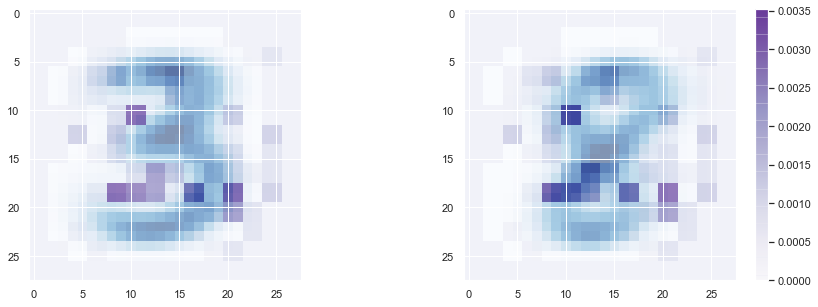

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
df['clipped_vi'] = df.vi.apply(lambda x: max(x,0))
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

In [56]:
dm = MNISTDataModule()
dm.setup()
model = UltraLiteMNIST()
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, dm)

X_train = dm.train_dataset.dataset.data
y_train = dm.train_dataset.dataset.targets

X_test = dm.test_dataset.data
y_test = dm.test_dataset.targets

print('training acc: ', torch.sum(y_train == torch.round(model(X_train))).item() / len(y_train) * 1.0)
acc0 = torch.sum(y_test == torch.round(model(X_test))).item() / len(y_test) * 1.0
acc0

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 3.1 K 
1 | layer_3 | Linear | 5     
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

training acc:  0.9923218160574194


0.9818548387096774

In [20]:
# 2x2 dropout

results = []
chunk_size = 2
lam0 = np.sqrt(X_train.shape[0])
for j in np.arange(0, 28, chunk_size):
    print(j)
    for k in np.arange(0, 28, chunk_size):
        Xj_train = dropout_chunk(X_train, j, k, chunk_size)
        Xj_test = dropout_chunk(X_test, j, k, chunk_size)
        yhat = torch.round(model(Xj_test))
        #lv = LazyVI(model, lam=lam0)
        #lv.fit(Xj_train, y_train)
        acc_jk = torch.sum(y_test == yhat).item() / len(y_test) * 1.0
        for jj in range(j, j+chunk_size):
            for kk in range(k, k+chunk_size):
                results.append([jj, kk, acc_jk, acc0])

0
2
4
6
8
10
12
14
16
18
20
22
24
26


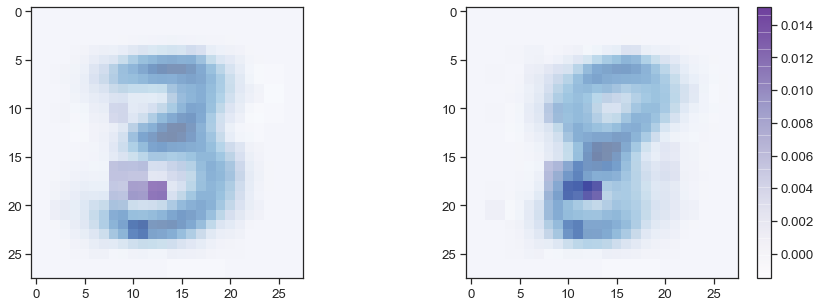

In [21]:
df = pd.DataFrame(results, columns=['j', 'k', 'reduced_accuracy', 'full_accuracy'])
df['vi'] = df.full_accuracy - df.reduced_accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='vi'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='vi'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

In [23]:
# 2x2 dropout

results = []
chunk_size = 1
lam0 = np.sqrt(X_train.shape[0])
for j in np.arange(0, 28, chunk_size):
    print(j)
    for k in np.arange(0, 28, chunk_size):
        Xj_train = dropout_chunk(X_train, j, k, chunk_size)
        Xj_test = dropout_chunk(X_test, j, k, chunk_size)
        yhat = torch.round(model(Xj_test))
        #lv = LazyVI(model, lam=lam0)
        #lv.fit(Xj_train, y_train)
        acc_jk = torch.sum(y_test == yhat).item() / len(y_test) * 1.0
        for jj in range(j, j+chunk_size):
            for kk in range(k, k+chunk_size):
                results.append([jj, kk, acc_jk, acc0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


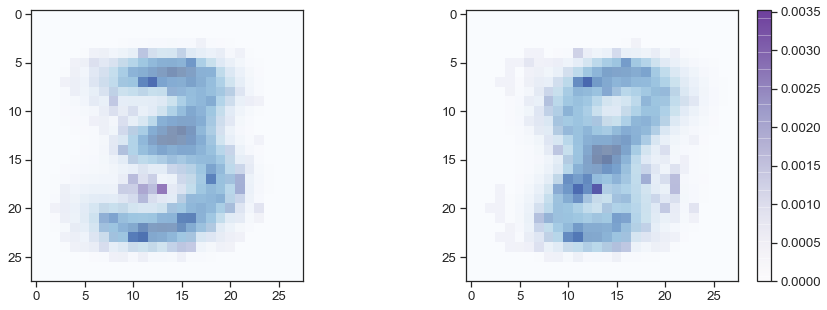

In [24]:
df = pd.DataFrame(results, columns=['j', 'k', 'reduced_accuracy', 'full_accuracy'])
df['vi'] = df.full_accuracy - df.reduced_accuracy
df['clipped_vi'] = df.vi.apply(lambda x: max(0,x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

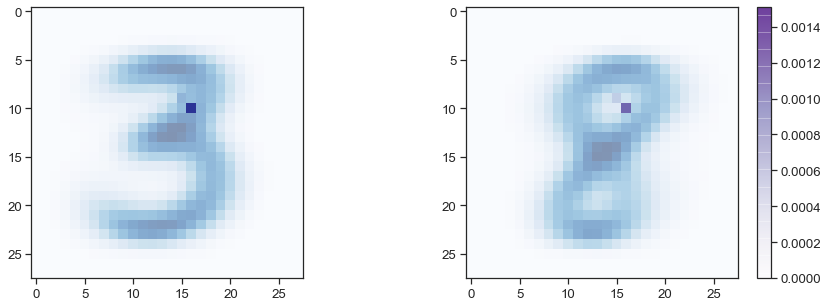

In [38]:
df = pd.read_csv('../paper_simulations/results/mnist_100.0pct.csv')
#df = pd.DataFrame(results, columns=['j', 'k', 'reduced_accuracy', 'full_accuracy'])
#df['vi'] = df.full_accuracy - df.reduced_accuracy
df['clipped_vi'] = df.vi.apply(lambda x: max(0,x))
#df['adj_vi'] = df.vi + abs(df.vi.min())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.figsize=(15,5)
ax1.imshow(X_train[np.where(y_train==0)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im1= ax1.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)
#ax1.colorbar()
ax2.imshow(X_train[np.where(y_train==1)[0]].detach().numpy().mean(axis=0), cmap='Blues')
im2 = ax2.imshow(df.pivot_table(index='j', columns='k', values='clipped_vi'), cmap='Purples', alpha=.5)

fig.colorbar(im1)

In [29]:
df.vi.min()

-0.0136088709677419